# Task 1: Learn to Overfit One-Instance

In [709]:
import sys
sys.path.append('../../models/')
import bimodal

In [710]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import astunparse
import myast

In [711]:
from numpy import multiply as np_mult, exp, dot, outer

In [664]:
MEMSIZE = 2
code = "f(x)"
node = ast.parse(code)
myast_node = myast.MyAST(node=node)
utter = 'blah'
train_pairs = [(utter, myast_node)]

def reset_model():
    global model
    
    reload(bimodal);

    model = bimodal.BiModal(
        train_pairs = train_pairs,
        size = 4,
        min_count = None,
        workers = 1,
        iter_ = 100,
        null_word=False,
        sample = None,
        additive = True,
        memsize_k = MEMSIZE,
        memsize_i = MEMSIZE,
        alpha = 1,  # CAUTION!!!!!!!!!!!!
        seed = 1,
        train_on_init=False)

    model.neg_labels = np.array([1, 0])

reset_model()

In [5]:
ptree1 = ([], 
          [myast.SimpleAstNode(node_type=ast.Name),
           myast.SimpleAstNode(field_name='func')],
          myast.SimpleAstNode(field_name='id'),
          myast.SimpleAstNode(content='f'))
ptree2 = ([myast.SimpleAstNode(content='f')], 
          [myast.SimpleAstNode(node_type=ast.Name),
           myast.SimpleAstNode(field_name='args')],
          myast.SimpleAstNode(field_name='id'),
          myast.SimpleAstNode(content='x'))
next_ptree = ptree1
ptree1, ptree2
# terminals, ancestors, parent, children

# Linearly separable. we want the model to learn to distinguish 
# these two.

(([], [NODE_Name, FIELD_func], FIELD_id, f),
 ([f], [NODE_Name, FIELD_args], FIELD_id, x))

In [6]:
def show_weights(model, i_idxs, k_idxs, l_idxs, r_idxs):
    assert len(i_idxs) == model.hmati.shape[0]
    assert len(k_idxs) == model.hmatk.shape[0]
    assert len(l_idxs) > 0
    assert len(r_idxs) > 1

    hmati = model.hmati  # memsize_i * vector_size
    hmatk = model.hmatk  # memsize_k * vector_size
    i_vecs = model.syn0i[i_idxs]  # memsize_i * vector_size
    k_vecs = model.syn0k[k_idxs]  # memsize_k * vector_size
    l_vecs = model.syn0l[l_idxs]  # arbitrary * vector_size
    r_vecs = model.syn1r[r_idxs]  # num_candidates * vector_size
    b = model.syn1b[r_idxs]  # 1 * num_candidates

    c = np.multiply(i_vecs, hmati).sum(0) + \
            np.multiply(k_vecs, hmatk).sum(0)  # 1 * vector_size
    l = l_vecs.mean(0)  # 1 * vector_size

    if model.additive:
        h = c + l  # 1 * vector_size
    else:
        h = np.multiply(c, l)

    # weights: outputs of the output-layer nodes
    weights = np.exp(np.dot(h, r_vecs.T) + b)  # 1 * num_candidates
    #     for r_idx, w in zip(r_idxs, weights):
    #         print w, r_idx
    return weights

In [229]:
def prepare_iklr(utter, ptree):
    terminals, ancestors, parent, children = ptree
    l_idxs = bimodal.get_l_idxs(model, utter)
    # print 'l_idxs', l_idxs, utter

    k_idxs = [model.vocab_k[x] for x in reversed(terminals)]
    k_idxs += [0] * (model.memsize_k - len(k_idxs))  # padding
    # print 'k_idxs', k_idxs, terminals

    i_idxs = [model.vocab_i[x] for x in ancestors]
    i_idxs += [0] * (model.memsize_i - len(i_idxs))  # padding
    # print 'i_idxs', i_idxs, ancestors

    r_pos_idx, r_neg_idxs = bimodal.find_r_idxs_train(
        model, parent, children)
    # print 'r_pos_idx', r_pos_idx
    # print 'r_neg_idxs', r_neg_idxs

    # print 'parent', parent
    # print 'children', children

    return i_idxs, k_idxs, l_idxs, r_pos_idx, r_neg_idxs

iklr1 = prepare_iklr(utter, ptree1)
iklr2 = prepare_iklr(utter, ptree2)
def train_and_swap():
    global next_ptree
    next_ptree = ptree2 if next_ptree == ptree1 else ptree1
    label = 'TRAINING X' if next_ptree == ptree2 else 'TRAINING F'
    terminals, ancestors, parent, children = next_ptree
    weights_before4 = show_weights(model, iklr1[0], iklr1[1], iklr1[2], [4,5])
    weights_before5 = show_weights(model, iklr2[0], iklr2[1], iklr2[2], [4,5])
    
    i_idxs, k_idxs, l_idxs, r_pos_idx, r_neg_idxs = \
        prepare_iklr(utter, next_ptree)
    print r_pos_idx, r_neg_idxs[0]
    bimodal.train_a_pair(model, i_idxs, k_idxs, l_idxs, 
                         r_pos_idx, r_neg_idxs, model.alpha)
    weights_after4 = show_weights(model, iklr1[0], iklr1[1], iklr1[2], [4,5])
    weights_after5 = show_weights(model, iklr2[0], iklr2[1], iklr2[2], [4,5])

    positions = np.array([1,2,4,5,8,9,11,12])
    plt.bar(positions,
            np.concatenate(
            (weights_before4,weights_before5,
             weights_after4,weights_after5)))
    plt.xticks(positions+0.5, ['FF','FX','XF','XX']*2)
    plt.title(label)

5 4


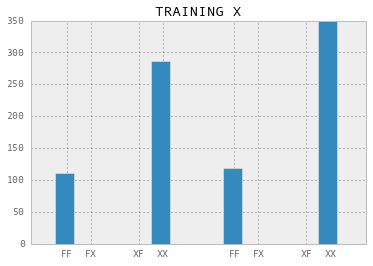

In [683]:
train_and_swap()

In [288]:
i_idxs, k_idxs, l_idxs, r_pos_idx, r_neg_idxs = iklr1

In [98]:
i_idxs, k_idxs, l_idxs, r_pos_idx, r_neg_idxs = iklr2

In [447]:
hmati = model.hmati  # memsize_i * vector_size
hmatk = model.hmatk  # memsize_k * vector_size
i_vecs = model.syn0i[i_idxs]  # memsize_i * vector_size
k_vecs = model.syn0k[k_idxs]  # memsize_k * vector_size
l_vecs = model.syn0l[l_idxs]  # arbitrary * vector_size
print 'hmati'
print hmati
print 'hmatk'
print hmatk

hmati
[[ 0.49609876  0.29516587  0.4892112   0.43958676]
 [ 0.49988252  2.37215805  0.53028822  0.77694088]]
hmatk
[[ 0.50026083  1.03371394  0.5140211   0.80243039]
 [ 0.50128168  0.2684443   0.48784003  0.43515486]]


In [290]:
c = np_mult(i_vecs, hmati).sum(0) + \
    np_mult(k_vecs, hmatk).sum(0)  # 1 * vector_size
l = l_vecs.mean(0)  # 1 * vector_size

assert model.additive
h = c + l  # 1 * vector_size

print 'c', c
print 'h', h

c [  5.53919040e-02  -4.62169409e+00   1.28126517e-03  -4.76013452e-01]
h [ 0.01018697 -4.76790237 -0.07225341 -0.53727841]


In [291]:
r_indices = [r_pos_idx] + r_neg_idxs
r_vecs = model.syn1r[r_indices]  # (1 + negative) * vector_size
b = model.syn1b[r_indices]  # 1 * (1 + negative)
print 'r_vecs'
print r_vecs
print 'b'
print b

r_vecs
[[ 0.06446565 -1.58717561  0.05181413 -0.39819199]
 [ 0.05000554  1.58362257  0.20109867  0.48790494]]
b
[ 0.00802556 -0.02759348]


In [301]:
f = 1. / (1. + exp(- dot(h, r_vecs.T) - b))  # 1 * (1 + negative)
print 'f', f

f [  9.99588907e-01   3.84326704e-04]


In [304]:
print 'weights'
print dot(h, r_vecs.T) + b
print ('exp(weights)')
print exp(dot(h, r_vecs.T) + b)

weights
[ 7.79635096 -7.86363316]
exp(weights)
[  2.43171240e+03   3.84474464e-04]


In [293]:
g = (model.neg_labels[:len(r_indices)] - f) * model.alpha  # 1 * (1 + negative)
print 'g', g
print 'alpha', model.alpha

g [ 0.00041515 -0.00038792]
alpha 1.0


In [294]:
neu1e = dot(g, r_vecs)  # 1 * vector_size
print 'EH', neu1e

EH [  7.36432577e-06  -1.27323550e-03  -5.65005694e-05  -3.54578026e-04]


In [295]:
print 'outer(g,h)'
print outer(g,h)

outer(g,h)
[[  4.22908197e-06  -1.97937727e-03  -2.99957379e-05  -2.23049173e-04]
 [ -3.95176964e-06   1.84958416e-03   2.80288363e-05   2.08423236e-04]]


In [296]:
model.syn1b[r_indices] += g

b = model.syn1b[r_indices]  # 1 * (1 + negative)
print 'b'
print b

b
[ 0.00844071 -0.02798141]


In [297]:
model.syn1r[r_indices] += outer(g, h)
r_vecs = model.syn1r[r_indices]  # (1 + negative) * vector_size
print 'r_vecs'
print r_vecs

r_vecs
[[ 0.06446988 -1.58915496  0.05178413 -0.39841503]
 [ 0.05000159  1.58547211  0.20112669  0.48811337]]


In [298]:
assert model.additive
neu1e_c = neu1e
neu1e_l = neu1e

In [299]:
model.syn0i[i_idxs] += np_mult(hmati, neu1e_c)
model.syn0k[k_idxs] += np_mult(hmatk, neu1e_c)
model.hmati += np_mult(i_vecs, neu1e_c)
model.hmatk += np_mult(k_vecs, neu1e_c)
model.syn0l[l_idxs] += neu1e_l / len(l_idxs)

# Conclusion
- Initialization matters
  - when I change the initialization of `hmati` and `hmatk` and `syn1b` to the way dictated by the paper, I was able to make the training process coverge to a desired state.
    - Actually, only the change of the initializations of `hmati` and `hmatk` is necessary.
    - Anyway, the changes have been adapted to the current implementation now.
- Learning rate matters
  - setting `alpha` to 1 works great.
  - 0.25 works fine
  - setting `alpha` to 0.025 (gensim's default learning rate) doesn't.
- Overflow in np.exp and np.multiply are dangerous.
  - The `exp(h.dot(r_vecs.T))` value goes up and up and won't stop. Do something about it??

# Task 2: Test NL-PL Matching

Do not need the above code.

## 2.1 One-to-one mapping

In [714]:
import sys
sys.path.append('../../models/')
import bimodal

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import astunparse
import myast

from numpy import multiply as np_mult, exp, dot, outer

MEMSIZE = 10

codes = ["f(x)", "g(x)", "h(x)", "r(x)", "t(x)"]
utters = ['f', 'g', 'h', 'r', 't']
nodes = [ast.parse(x) for x in codes]
myasts = [myast.MyAST(node=x) for x in nodes]
train_pairs = zip(utters, myasts)

reload(bimodal);

model = bimodal.BiModal(
    train_pairs = train_pairs,
    size = 20,
    min_count = None,
    workers = 1,
    iter_ = 100,
    null_word = False,
    sample = None,
    additive = True,
    memsize_k = MEMSIZE,
    memsize_i = MEMSIZE,
    alpha = 0.25,  # CAUTION!!!!!!!!!!!!
    seed = 1,
    train_on_init=True)

for utter in utters:
    my_callback = model.getSampleCallback(utter)
    myast_sampled = myast.MyAST.sample_from_root(
        memsize_k=MEMSIZE, memsize_i=MEMSIZE, callback=my_callback)

    code_sampled = astunparse.unparse(myast_sampled.node)
    print 'utter=%s, code=%s'%(utter, code_sampled.strip())

utter=f, code=f(x)
utter=g, code=g(x)
utter=h, code=h(x)
utter=r, code=r(x)
utter=t, code=t(x)


## 2.2 Many-to-one Mapping

In [719]:
import sys
sys.path.append('../../models/')
import bimodal

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import astunparse
import myast

from numpy import multiply as np_mult, exp, dot, outer

MEMSIZE = 10

codes = ["f(x)", "g(x)", "h(x)", "r(x)", "t(x)"]
utters = ['f', 'g', 'h', 'r', 't']
utters1 = [x+'1' for x in utters]
utters2 = [x+'2' for x in utters]
utters3 = [x+'3' for x in utters]
nodes = [ast.parse(x) for x in codes]
myasts = [myast.MyAST(node=x) for x in nodes]
train_pairs = zip(utters1, myasts) + zip(utters2, myasts) + zip(utters3, myasts)

reload(bimodal);

model = bimodal.BiModal(
    train_pairs = train_pairs,
    size = 20,
    min_count = None,
    workers = 1,
    iter_ = 100,
    null_word = False,
    sample = None,
    additive = True,
    memsize_k = MEMSIZE,
    memsize_i = MEMSIZE,
    alpha = 0.25,  # CAUTION!!!!!!!!!!!!
    seed = 1,
    train_on_init=True)

for utter, _ in train_pairs:
    my_callback = model.getSampleCallback(utter)
    myast_sampled = myast.MyAST.sample_from_root(
        memsize_k=MEMSIZE, memsize_i=MEMSIZE, callback=my_callback)

    code_sampled = astunparse.unparse(myast_sampled.node)
    print 'utter=%s, code=%s'%(utter, code_sampled.strip())

utter=f1, code=f(x)
utter=g1, code=g(x)
utter=h1, code=h(x)
utter=r1, code=r(x)
utter=t1, code=t(x)
utter=f2, code=f(x)
utter=g2, code=g(x)
utter=h2, code=h(x)
utter=r2, code=r(x)
utter=t2, code=t(x)
utter=f3, code=f(x)
utter=g3, code=g(x)
utter=h3, code=h(x)
utter=r3, code=r(x)
utter=t3, code=t(x)


## 2.3 Unseen Words

In [733]:
import sys
sys.path.append('../../models/')
import bimodal

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import ast
import astunparse
import myast

from numpy import multiply as np_mult, exp, dot, outer

MEMSIZE = 10

codes = ["f(x)", "g(x)", "h(x)", "r(x)", "t(x)"]
utters = ['f', 'g', 'h', 'r', 't']
utters1 = [x+'1' for x in utters]
utters2 = [x+'2' for x in utters]
utters3 = [x+'3' for x in utters]
nodes = [ast.parse(x) for x in codes]
myasts = [myast.MyAST(node=x) for x in nodes]
train_pairs = zip(utters1, myasts) + zip(utters2, myasts) + zip(utters3, myasts)

reload(bimodal);

model = bimodal.BiModal(
    train_pairs = train_pairs,
    size = 20,
    min_count = None,
    workers = 1,
    iter_ = 100,
    null_word = True,  # <-- this is changed!!
    sample = None,
    additive = True,
    memsize_k = MEMSIZE,
    memsize_i = MEMSIZE,
    alpha = 0.25,  # CAUTION!!!!!!!!!!!!
    seed = 1,
    train_on_init=True)

utters_trained = [x[0] for x in train_pairs]
for utter in utters_trained + ['f1 Unknown Word', 'xxx']:
    my_callback = model.getSampleCallback(utter)
    myast_sampled = myast.MyAST.sample_from_root(
        memsize_k=MEMSIZE, memsize_i=MEMSIZE, callback=my_callback)

    code_sampled = astunparse.unparse(myast_sampled.node)
    print 'utter=%s, code=%s'%(utter, code_sampled.strip())

utter=f1, code=f(x)
utter=g1, code=g(x)
utter=h1, code=h(x)
utter=r1, code=r(x)
utter=t1, code=t(x)
utter=f2, code=f(x)
utter=g2, code=g(x)
utter=h2, code=h(x)
utter=r2, code=r(x)
utter=t2, code=t(x)
utter=f3, code=f(x)
utter=g3, code=g(x)
utter=h3, code=h(x)
utter=r3, code=r(x)
utter=t3, code=t(x)
utter=f1 Unknown Word, code=f(x)
utter=xxx, code=f(x)
